# Machine Learning HW2
### Author: Ze Yang (zey@andrew.cmu.edu)

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import rpy2
%reload_ext rpy2.ipython
import time
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, \
    roc_curve, confusion_matrix, auc, mean_squared_error
from sklearn.linear_model import LinearRegression, LogisticRegression, \
    LassoCV, RidgeCV, RidgeClassifierCV, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.partial_dependence import partial_dependence
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from pygam import LogisticGAM
from pygam.utils import generate_X_grid
from copy import copy
from progressbar import ProgressBar
from tabulate import tabulate

# Bad Validation

## Correlations Between Noise

In [84]:
import scipy

#You get to observe a bunch of data (that turns out to be worthless)
#Returns a data set with 100 variables and n data points
#The first 100 columns are the X variables (called X1,...X100)
#The last column is the response (called y)
def get_data(n):
    p=1000
    X = scipy.stats.norm().rvs(n*p).reshape((n,p))
    Y = scipy.stats.norm().rvs(n)
    return(X,Y)

#Generate some data
n = 100
X, y = get_data(n)

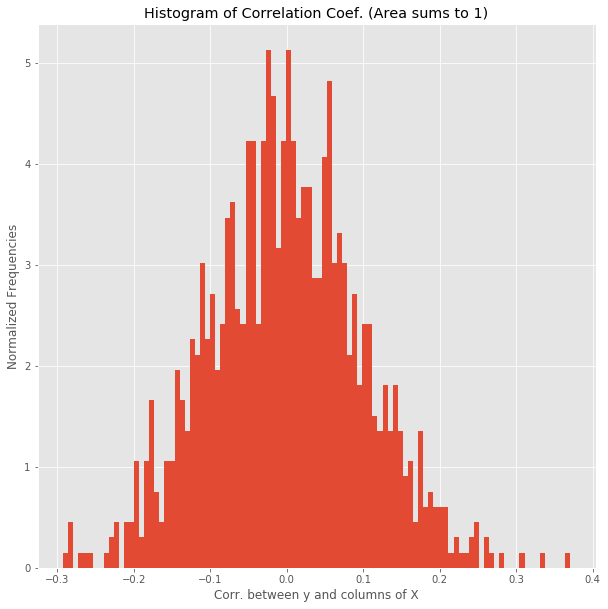

In [85]:
corr = np.apply_along_axis(
    scipy.stats.pearsonr, 0, X, y=y)[0,:]
fig, ax = fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.hist(corr, 100, normed=True)
_ = ax.update({'xlabel':'Corr. between y and columns of X', 
               'ylabel':'Normalized Frequencies', 
               'title':'Histogram of Correlation Coef. (Area sums to 1)'})

## Find "Good" Variables from Noise

In [86]:
good_indices = np.abs(corr) > 0.2
X_good = X[:,good_indices]
X_good.shape

(100, 43)

In [87]:
X_train, X_valid = X_good[:80,:], X_good[80:,:]
y_train, y_valid = y[:80], y[80:]
X_train.shape, X_valid.shape

((80, 43), (20, 43))

In [88]:
lasso_cv = LassoCV(cv=10, normalize=True)
lasso_cv.fit(X_train, y_train)
mse_path, alpha_path = lasso_cv.mse_path_, lasso_cv.alphas_
cvmse_mean = np.mean(mse_path,1)
best_alpha = alpha_path[np.argmin(cvmse_mean)]
best_cvmse_mean = np.min(cvmse_mean)

y_pred = lasso_cv.predict(X_valid)
valid_mse = mean_squared_error(y_valid, y_pred)
print('Best Alpha:', best_alpha)
print('Mean CV MSE (at best Alpha):', best_cvmse_mean)
print('Validation MSE:', valid_mse)

Best Alpha: 0.00360931916786
Mean CV MSE (at best Alpha): 0.680193979962
Validation MSE: 0.615178412058


## Fail to Generalize to Unseen Dataset

In [89]:
X_test, y_test = get_data(n)
X_test_good = X_test[:,good_indices]
y_test_pred = lasso_cv.predict(X_test_good)
test_mse = mean_squared_error(y_test, y_test_pred)
print('Test MSE:', test_mse)

Test MSE: 1.53744576645


- Test MSE is 1.537, far from Training/Validation MSE, which is about 0.6~0.7.
- The reason of this is: we manually select good features among 1000 features in Training-Validation set that has high correlation with $y$, and wish that correlation can generalize to test set. However, it's obvious that those correlations are due to noise, and don't exist on new test set.
- As a result, the joint distribution of our selected "good" features and $y$ are very different on Training-Validation set and Test set. So we can no longer do well with our model that relies only on Training-Validation set.
- This can be kind-of thought as overfitting to the Training-Validation set.

# Problem 2

In [136]:
df2_train = pd.read_csv('problem2_train.csv')
df2_test = pd.read_csv('problem2_test.csv')
X_train, y_train = df2_train.iloc[:,1:].values, df2_train['y'].values
X_test, y_test = df2_test.iloc[:,1:].values, df2_test['y'].values
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(50, 20) (50,)
(10000, 20) (10000,)


## Linear Regression

In [137]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
y_pred_train = lr_reg.predict(X_train)
y_pred_test = lr_reg.predict(X_test)
print('Train MSE:', mean_squared_error(y_train, y_pred_train))
print('Test MSE:', mean_squared_error(y_test, y_pred_test))

Train MSE: 0.0469252059528
Test MSE: 2.44413436385


- Sample size is small (50), number of features is large (20). There is huge discrepancy between training MSE and test MSE. These are signs of high variance. Therefore we should try to add bias, reduce variance.

## Ridge and Lasso

In [138]:
ridge_cv = RidgeCV(
    alphas=np.exp(np.linspace(-5, 5, 100)),
    cv=10, normalize=True)
ridge_cv.fit(X_train, y_train)
print('Ridge CV best alpha:', ridge_cv.alpha_)
y_pred = ridge_cv.predict(X_test)
print('Test MSE (Ridge):', mean_squared_error(y_test, y_pred))

lasso_cv = LassoCV(
    alphas=np.exp(np.linspace(-5, 5, 100)),
    cv=10, normalize=True)
lasso_cv.fit(X_train, y_train)
print('Lasso CV best alpha:', lasso_cv.alpha_)
y_pred = lasso_cv.predict(X_test)
print('Test MSE (lasso):', mean_squared_error(y_test, y_pred))

Ridge CV best alpha: 0.518629431028
Test MSE (Ridge): 2.3730919436
Lasso CV best alpha: 0.00673794699909
Test MSE (lasso): 2.23804607596


- The test MSE was improved indeed, by 2.91% (Ridge) and 8.43% (Lasso).

## Glmnet Version

[1] "CV best lambda: 0.150747127365337"
[1] "Test MSE (Ridge): 2.13116573264519"


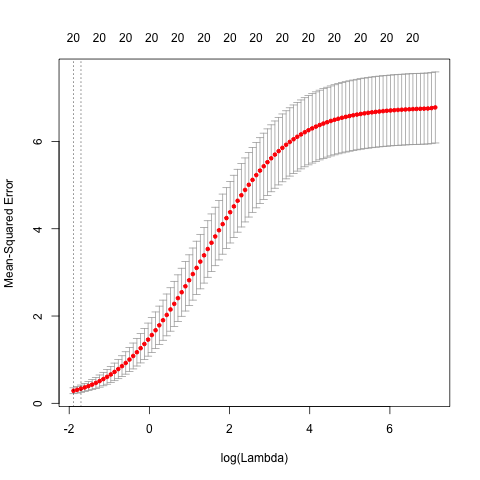

In [139]:
%%R -i X_train -i X_test -i y_train -i y_test
library(glmnet)
cv_ridge = cv.glmnet(X_train, as.vector(y_train), alpha=0)
opt_lambda = cv_ridge$lambda.min
plot(cv_ridge)
y_pred = predict(cv_ridge, s=cv_ridge$lambda.1se, newx=X_test)
mse_ridge = mean((y_pred-as.vector(y_test))^2)
print(paste('CV best lambda:',opt_lambda))
print(paste('Test MSE (Ridge):',mse_ridge))

[1] "CV best lambda: 0.00471192685300806"
[1] "Test MSE (Lasso): 2.30536445089176"


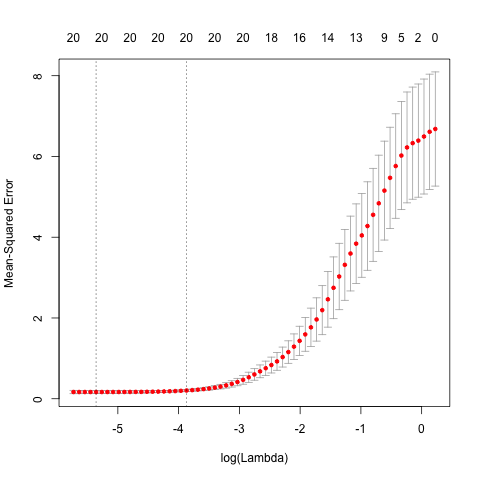

In [202]:
%%R
cv_lasso = cv.glmnet(X_train, as.vector(y_train), 
                     alpha=1)
opt_lambda = cv_lasso$lambda.min
plot(cv_lasso)
y_pred = predict(cv_lasso, s=cv_lasso$lambda.1se, newx=X_test)
mse_lasso = mean((y_pred-as.vector(y_test))^2)
print(paste('CV best lambda:',opt_lambda))
print(paste('Test MSE (Lasso):',mse_lasso))

- The `glmnet` version of Lasso and Ridge improved the test MSE was by 12.8% (Ridge) and 5.67% (Lasso).

# Problem 3

In [2]:
df3_train = pd.read_csv('problem3_train.csv')
df3_test = pd.read_csv('problem3_test.csv')
X_train, y_train = df3_train.iloc[:,1:].values, df3_train['y'].values
X_test, y_test = df3_test.iloc[:,1:].values, df3_test['y'].values
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(300, 50) (300,)
(10000, 50) (10000,)


## Logistic Regression

In [3]:
logit_clf = LogisticRegression(C=10e-8)
logit_clf.fit(X_train, y_train)
y_pred_train = logit_clf.predict(X_train)
y_pred_test = logit_clf.predict(X_test)
print('Train misclf error:', 1-accuracy_score(y_train, y_pred_train))
print('Test misclf error:', 1-accuracy_score(y_test, y_pred_test))

Train misclf error: 0.15
Test misclf error: 0.2598


- Test misclassification error is 0.2568, while training misclf error is 0.15.
- There is still significant gap between, and we still have a small training set in this problem. The test error is likely to be reduced by adding bias.

## Ridge and Lasso

In [4]:
# ridge
def accuracy_score__(y_test, y_pred): 
    return np.sum(y_test == y_pred)/len(y_test)
accuracy_scorer = make_scorer(
    accuracy_score__, needs_proba=False, 
    greater_is_better=True)

ridge_cv = RidgeClassifierCV(
    alphas=np.exp(np.linspace(-4, 4, 100)),
    cv=10, normalize=True, scoring=accuracy_scorer)
ridge_cv.fit(X_train, y_train)
print('Ridge CV best alpha:', ridge_cv.alpha_)
y_pred = ridge_cv.predict(X_test)
print('Test misclf error (Ridge):', 
      1-accuracy_score(y_test, y_pred))

# lasso
lasso_clf = LogisticRegression(penalty='l1')
param_grid = {
    'C': np.exp(np.linspace(-4, 4, 100)),
}
kfold = StratifiedKFold(
    n_splits=10, shuffle=True, random_state=1)
gscv = GridSearchCV(
    lasso_clf, param_grid, 
    scoring=accuracy_scorer, 
    n_jobs=-1, cv=kfold, verbose=0)
gs_result = gscv.fit(X_train, y_train)
for param, val in gs_result.best_params_.items():
    setattr(lasso_clf, param, val)
lasso_clf.fit(X_train, y_train)
y_pred = lasso_clf.predict(X_test)
print('Ridge CV best alpha:', gs_result.best_params_['C'])
print('Test misclf error (lasso):', 
      1-accuracy_score(y_test, y_pred))

Ridge CV best alpha: 0.0183156388887
Test misclf error (Ridge): 0.2308
Ridge CV best alpha: 0.085038901316
Test misclf error (lasso): 0.1926


- The test misclf error was improved to 0.1926 by Lasso, and to 0.2308 by ridge; from that of 0.25 (vanilla Logistic regression). 
- The Lasso achieved about 23% improvement.

[1] "CV best lambda: 0.0242526252488269"
[1] "Test misclf error (Lasso): 0.1988"


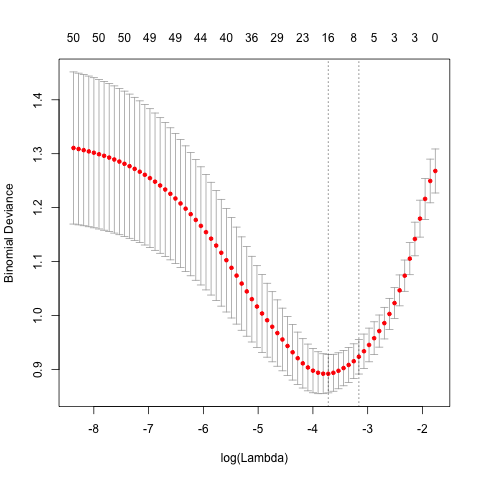

In [64]:
%%R -i X_train -i X_test -i y_train -i y_test
library(glmnet)
cv_lasso = cv.glmnet(X_train, as.vector(y_train), 
                     alpha=1, family='binomial')
opt_lambda = cv_lasso$lambda.min
plot(cv_lasso)
y_pred = predict(cv_lasso, s=cv_lasso$lambda.1se, 
                 newx=X_test, type='response')
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <=0.5] = 0
misclf_lasso = sum(as.vector(y_test) != y_pred)/length(y_pred)
print(paste('CV best lambda:',opt_lambda))
print(paste('Test misclf error (Lasso):',misclf_lasso))

- `glmnet` yields a slightly different result. It chooses a smaller lambda, but has approximately the same test misclf error.

## Biasing Further?

In [47]:
# what's the training error of lasso?
y_train_pred = lasso_clf.predict(X_train)
print('Training misclf error (lasso):', 
      1-accuracy_score(y_train, y_train_pred))

Training misclf error (lasso): 0.2


- No, we can't do that.
- The test misclf error is now 0.1926 by using Lasso, while the training misclf error is 0.2, very close to the test error.
- With the biased linear model, we've already done as well on test set as we did on the training set. That implies the variance can't be reduced further. The misclf error we have now is mainly due to the bias of linear model
- We need to go for other models.

## Random Forest

[1] "Training misclf error (RF): 0"
[1] "OOB misclf error (RF): 0.246666666666667"
[1] "Test misclf error (RF): 0.2252"


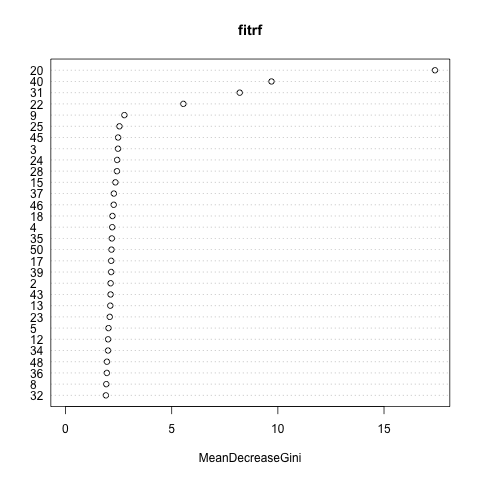

In [18]:
%%R -i X_train -i X_test -i y_train -i y_test
library(randomForest)
y_train = as.factor(y_train)
y_test = as.factor(y_test)

fitrf = randomForest(
    X_train, y_train, ntree=1000)

y.pred.train = predict(fitrf, newdata=X_train, type='class')
y.pred.test = predict(fitrf, newdata=X_test, type='class')
y.pred.oob = predict(fitrf, type='class')

misclf.rf.train = sum(y_train != y.pred.train)/length(y_train)
misclf.rf.oob = sum(y_train != y.pred.oob)/length(y_train)
misclf.rf.test = sum(y_test != y.pred.test)/length(y_test)

print(paste('Training misclf error (RF):',misclf.rf.train))
print(paste('OOB misclf error (RF):',misclf.rf.oob))
print(paste('Test misclf error (RF):',misclf.rf.test))

varImpPlot(fitrf)

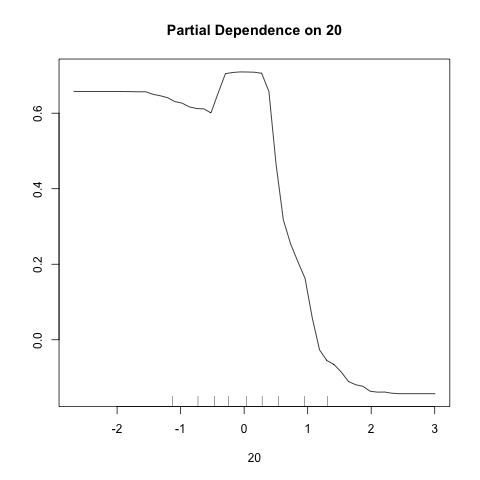

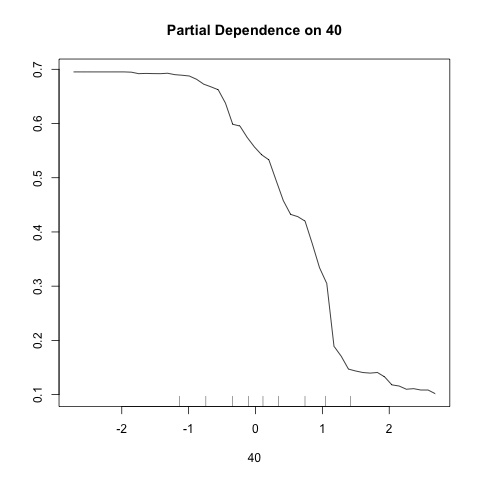

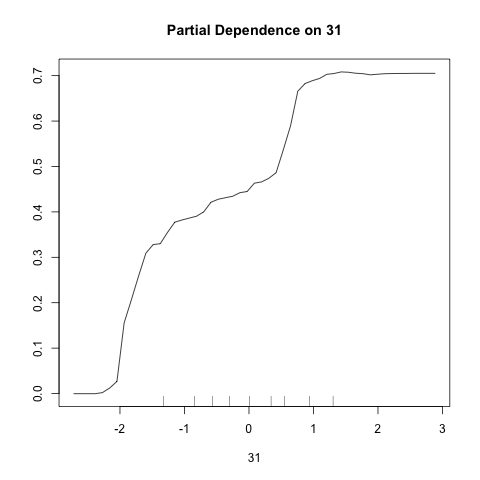

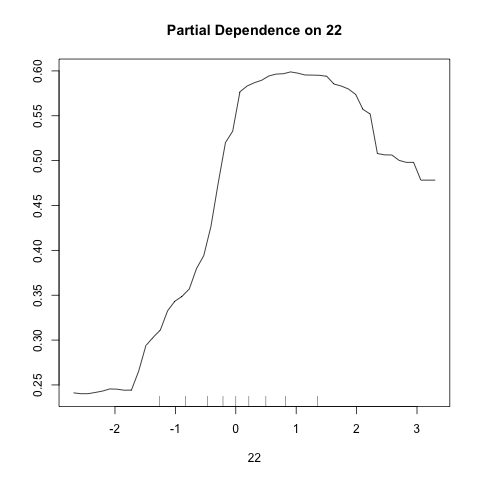

In [30]:
%%R
partialPlot(fitrf, X_train, x.var=20, which.class=1)
partialPlot(fitrf, X_train, x.var=40, which.class=1)
partialPlot(fitrf, X_train, x.var=31, which.class=1)
partialPlot(fitrf, X_train, x.var=22, which.class=1)

## Logistic GAM
- We learned from feature importance plot above that feature #20, #40, #31, #22 are the most important ones.
- And judging from the partial dependence plot, all of these features contribute to $y$ in a non-linear fashion.
- Therefore, we will include the local polynomials of these features, while leaving other less important features linear.
- We also manually select some features. We left those features with `MeanDecreaseGini` less than 2.5 to remove some of the noise (kinda like adding some L1 regularization). By doing so we only include 7 features to the model - the top 7 ones in the feature importance plot.
- Our final specification GAM model is:

$$
y \sim lo_{20}(X_{20})+lo_{40}(X_{40})+lo_{31}(X_{31})+lo_{22}(X_{22})+\beta_{25}X_{25}+\beta_{9}X_{9}+\beta_{45}X_{45}
$$

where $lo_i(\cdot)$ is a local polynomial smoothing function.

In [32]:
%%R
df.train = read.csv('problem3_train.csv')
df.test = read.csv('problem3_test.csv')
library(gam)
gamfit = gam(formula=y~lo(X20)+lo(X40)+lo(X31)+lo(X22)+X25+X9+X45, 
             family='binomial', data=df.train)

y.pred.test = predict(gamfit, newdata=df.test)
y.pred.test[y.pred.test > 0.5] = 1
y.pred.test[y.pred.test <=0.5] = 0
misclf.gam.test = sum(df.test['y'] != y.pred.test)/length(y_test)
print(paste('Train misclf error (gam):',misclf.gam.test))
print(paste('Test misclf error (gam):',misclf.gam.test))

[1] "Test misclf error (gam): 0.1474"


- We managed to reduce test misclassificataion error from 0.1988 (Lasso) to 0.1474 (GAM); which is about 26% improvement.